In [1]:
import torch
import torch.nn as nn
import torchvision # some builtin datasets
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader

import math
import matplotlib.pyplot as plt

from utils import ALL_LETTERS, N_LETTERS
from utils import load_data, letter_to_tensor, line_to_tensor, random_training_example

In [2]:
# Settings

# device config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

# hyper parameters
hidden_size = 128
learning_rate = 0.005

device: cuda


In [12]:
# Model
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, input_tensor, hidden_tensor):
        combined = torch.cat((input_tensor, hidden_tensor), 1).to(device)

        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)

        return output, hidden
    
    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [13]:
def category_from_output(output):
    category_idx = torch.argmax(output).item()
    return all_categories[category_idx]

In [14]:
category_lines, all_categories = load_data()
n_categories = len(all_categories)

rnn = RNN(input_size=N_LETTERS, hidden_size=hidden_size, output_size=n_categories).to(device)

In [22]:
# one step
input_tensor = letter_to_tensor("A").to(device)
hidden_tensor = rnn.init_hidden().to(device)

output, next_hidden = rnn(input_tensor, hidden_tensor)
print(output.size(), next_hidden.size())

torch.Size([1, 18]) torch.Size([1, 128])


In [6]:
# whole name
input_tensor = line_to_tensor('Bao').to(device)
hidden_tensor = rnn.init_hidden().to(device)
print(input_tensor.size(), hidden_tensor.size())

output, next_hidden = rnn(input_tensor[0], hidden_tensor)
print(output.size(), next_hidden.size())
print(category_from_output(output))

torch.Size([3, 1, 57]) torch.Size([1, 128])
Linear(in_features=185, out_features=128, bias=True)
torch.Size([1, 18]) torch.Size([1, 128])
Korean


In [16]:
# Train
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

def train(line_tensor, category_tensor):

    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        input_tensor_i = line_tensor[i].to(device)
        hidden = hidden.to(device)
        output, hidden = rnn(input_tensor_i, hidden) # feed one character at once
        
    loss = criterion(output, category_tensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

current_loss = 0
all_losses = []
plot_steps, print_steps = 1000, 5000
n_iters = 100000

for i in range(n_iters):
    category, line, category_tensor, line_tensor = random_training_example(category_lines, all_categories)
    category_tensor = category_tensor.to(device)
    
    output, loss = train(line_tensor, category_tensor)
    current_loss += loss

    if (i+1) % plot_steps == 0:
        all_losses.append(current_loss/plot_steps)
        current_loss = 0
    if (i+1) % print_steps == 0:
        guess = category_from_output(output)
        corret = "CORRECT" if guess == category else f"WRONG ({category})"
        print(f"{i+1} {(i+1)/n_iters*100} {loss:.4f} {line} / {guess} {corret}")


Parameter containing:
tensor([ 0.0206, -0.0569, -0.0004, -0.0428,  0.0673,  0.0166,  0.0206, -0.0188,
        -0.0711,  0.0330, -0.0166,  0.0043, -0.0265, -0.0145, -0.0458, -0.0276,
        -0.0615,  0.0103, -0.0633,  0.0675, -0.0313, -0.0357,  0.0506,  0.0381,
        -0.0653, -0.0262,  0.0638, -0.0339, -0.0451,  0.0164,  0.0045, -0.0724,
         0.0477, -0.0386, -0.0055,  0.0371,  0.0150, -0.0352,  0.0085, -0.0621,
        -0.0108,  0.0541,  0.0693,  0.0708, -0.0587, -0.0046,  0.0355, -0.0642,
         0.0369, -0.0265,  0.0570,  0.0387, -0.0662,  0.0145, -0.0129, -0.0040,
        -0.0322,  0.0503, -0.0362, -0.0343,  0.0410, -0.0596,  0.0586, -0.0588,
         0.0337,  0.0522,  0.0555,  0.0535, -0.0387,  0.0453, -0.0312, -0.0345,
         0.0190,  0.0185,  0.0524,  0.0531,  0.0649, -0.0413, -0.0543, -0.0534,
        -0.0015,  0.0046,  0.0327,  0.0605,  0.0251,  0.0335,  0.0030, -0.0284,
         0.0542, -0.0120, -0.0025, -0.0324,  0.0099, -0.0220, -0.0031,  0.0681,
        -0.0641, -

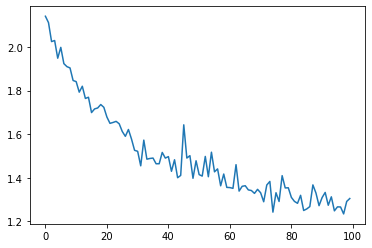

In [43]:
plt.figure()
plt.plot(all_losses)
plt.show()

In [44]:
# Evaluation

def predict(input_line):
    print(f"\n> {input_line}")
    with torch.no_grad():
        line_tensor = line_to_tensor(input_line)
        
        hidden = rnn.init_hidden()
    
        for i in range(line_tensor.size()[0]):
            line_tensor_i = line_tensor[i].to(device)
            hidden = hidden.to(device)
            output, hidden = rnn(line_tensor_i, hidden)
        
        guess = category_from_output(output)
        print(guess)


while True:
    sentence = input("Input:")
    if sentence == "quit":
        break
    
    predict(sentence)


> wan
Chinese

> WAN
Chinese

> BAO
Vietnamese

> GUI
Chinese

> HONG
Korean

> HELLO
Vietnamese

> TEST
Korean

> WHY
Korean

> QUIT
Korean


In [9]:
torch.save(model.state_dict(), "outputs/mnist_ffn.pth")